## Magnetotelluric (MT) inversion
### Background
Let's treat the magnetotelluric investigation, i.e. measuring electric and magnetic fields over a wide frequency ($\omega$) range to make a depth sounding. From the impedance $Z=E/H$ (e.g. $E_x$ and $H_y$) we compute the apparent resistivity
$$ \rho^a(\omega) = \frac{1}{\omega\mu}|Z|^2 $$
and phase
$$ \phi(\omega) = \tan^{-1}\frac{Z''}{Z'} $$
We plot the data in two separate plots with the periods as vertical axis going down (increasing penetration depth):

In [147]:
using PyPlot
function plotMTsounding(T, rhoa, phi)
    # plot apparent resistivity and phase over period in two subplots
    fig, ax = subplots(ncols=2, sharey=true)
    ax[1].loglog(rhoa, T)
    ax[1].invert_yaxis()
    ax[2].semilogy(phi*180/pi, T)
    ax[1].set_title("apparent resistivity")
    ax[2].set_title("phase")
    ax[1].set_xlabel(L"$\rho$ ($\Omega$m)")
    ax[2].set_xlabel(L"$\phi$ (°)")
    ax[1].set_ylabel(L"$T$ (s)")
    ax[1].grid()
    ax[2].grid()
end;

### Forward computation
The forward algorithm is described by Wait's (1955) algorithm. It returns apparent resistivity and phase as separate vectors for a given resistivity/thickness combination.

In [222]:
function mt1dfwd(period, r, d)
    # MT forward computation with Wait's algorithm
    # = mt1dfwd(resistivities,thicknesses,periods)
    my0 = 4*pi*1e-7;
    omega = 2 *pi ./ period;
    k1 = sqrt.(im * omega * my0 / r[1]);
    g = 1
    nlay=min(length(r),length(d)+1)
    for k = nlay-1:-1:1;    
        k1 = sqrt.(im * omega * my0 / r[k])
        k2 = sqrt.(im * omega * my0 / r[k+1])
        th = tanh.(k1*d[k])
        g = (g.*k2 + k1.*th) ./ (k1 + g.*k2.*th);    
    end
    z = im * omega ./ (k1 .* g)

    rhoa = mu0 ./ omega .* abs.(z).^2
    phi = angle.(z)
    return rhoa, phi
end;

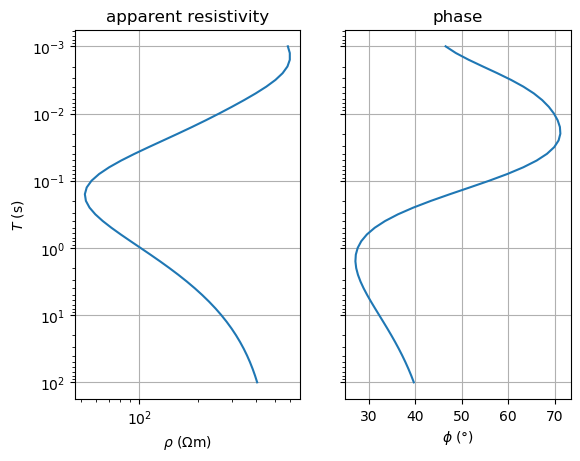

In [216]:
# Test the forward operator with a 3-layer model
rho = [500, 20, 500]
thk = [500, 500]
T = 10 .^ (-3:0.1:2)  # 1ms to 100s (typical AMT)
rhoa, phi = mt1dfwd(T, rho, thk)
plotMTsounding(T, rhoa, phi)

The good conductor shows with increased phases at about 10-20ms and decreased $\rho ^a$ at about 100-200ms. Play around to get a feeling how different models affect the curves.

In [217]:
# define a fixed-thickness forward operator for Occam inversion
thkVec = ones(30) * 50
mt1dsmooth(T, rho) = mt1dfwd(T, rho, thkVec);
r1, p1 = mt1dsmooth(T, ones(21)*20);

### Sensitivity

In [218]:
function MT1dSens(T, resistivity)
    rhoa, phi = mt1dsmooth(T, resistivity)
    Srhoa = zeros(length(T), length(resistivity))
    Sphi = zeros(length(T), length(resistivity))
    for i = 1:numlay
        resistivity1 = resistivity * 1.0 # make a copy!
        resistivity1[i] *= 1.1  # change by 10%
        rhoa1, phi1 = mt1dsmooth(T, resistivity1)
        Srhoa[:, i] = (rhoa1 - rhoa) ./ (resistivity1[i] - resistivity[i])
        Sphi[:, i] = (phi1 - phi) ./ (resistivity1[i] - resistivity[i])
    end
    return Srhoa, Sphi
end

MT1dSens (generic function with 2 methods)

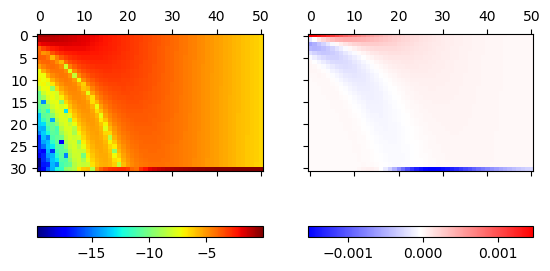

In [219]:
numlay = length(thkVec) + 1
resistivity = ones(numlay) * 100
Srhoa, Sphi = MT1dSens(T, resistivity)
fig, ax = subplots(ncols=2, sharey=true)
img = ax[1].matshow(transpose(log.(abs.(Srhoa))), cmap="jet");
colorbar(img, ax=ax[1], orientation="horizontal");
img = ax[2].matshow(transpose(Sphi), cmap="bwr");
colorbar(img, ax=ax[2], orientation="horizontal");

### Equivalency

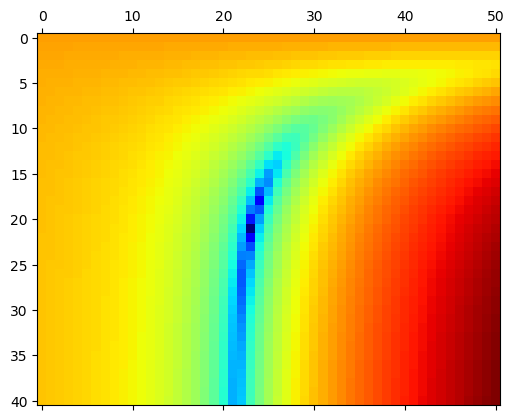

In [220]:
using LinearAlgebra
rho = [100.0, 1000.0, 100.0]  # resistivity vector (resistive anomaly)
thk = [500.0, 500.0]
rhoa, phi = mt1dfwd(T, rho, thk)
rhovals = 10 .^ (2:0.05:4)
thkvals = 10 .^ (2:0.03:3.5)
Phi = zeros(length(rhovals), length(thkvals))
for i = 1:length(rhovals)
    rho[2] = rhovals[i]
    for j = 1:length(thkvals)
        thk[2] = thkvals[j]
        rhoa1, phi1 = mt1dfwd(T, rho, thk)
        Phi[i, j] = norm(rhoa1-rhoa)
    end
end

matshow(log.(Phi))
set_cmap("jet")

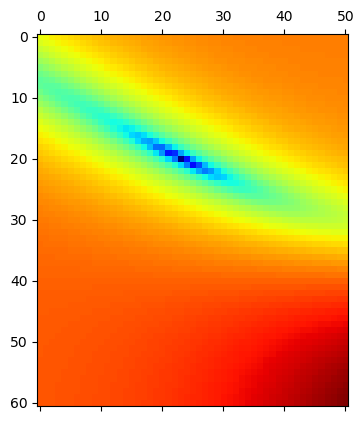

In [221]:
using LinearAlgebra
rho = [100.0, 10.0, 100.0]  # resistivity vector (conductive anomaly)
thk = [500.0, 500.0]
rhoa, phi = mt1dfwd(T, rho, thk)
rhovals = 10 .^ (0:0.05:3)
thkvals = 10 .^ (2:0.03:3.5)
Phi = zeros(length(rhovals), length(thkvals))
for i = 1:length(rhovals)
    rho[2] = rhovals[i]
    for j = 1:length(thkvals)
        thk[2] = thkvals[j]
        rhoa1, phi1 = mt1dfwd(T, rho, thk)
        Phi[i, j] = norm(rhoa1-rhoa)
    end
end

matshow(log.(Phi))
set_cmap("jet")

### Inversion
Now we (i.e. you) go for inversion. 

Tasks:
1. Compute synthetic data using using a three-layer case (e.g. a conductor)
1. Add Gaussian noise:
    * 3% (relative) to the apparent resistivity
    * 1° (absolute) to the phases
1. Use the sensitivity above to compute the Jacobian matrix for apparent resistivity only, using logarithmic $\rho$ and $\rho^a$ transformations.
1. Carry out an Occam-type inversion with fixed discretization and first-order smoothness constraints, first using apparent resistivity only. 
    * scale the inverse problem by the inverse of the error model
    * Adjust the regularization strength with the discrepancy principle ($\chi^2=1$).
1. Compute the model resolution matrix and the data information matrix. Display the whole matrices and their diagonals (over depth and period, respectively).
1. Extend the inversion to using both $\rho^a$ and $\phi$ values by concatenating both vectors (and also concatenating the Jacobian matrices). Keep making use of logarithmic resistivities but linear phases.
    * Combine the data to a long vector of $\log\rho^a$ and $\phi$, the error model likewise.
    * Write a Jacobian function that scales the individual sensitivities and concatenates them.
    * Scale the Jacobian by the inverse of the (now combined!) error model. 
    * Again adjust the regularization parameter so that $\chi^2=1$.
1. Compute model resolution and data information matrices. Is the model resolution improved by adding the phase data? How are the individual resistivity and phase data are connected to each other and to neighboring periods?
1. Do a Marquardt-type inversion of a three-layered Earth model (5 parameters):
    * start with a homogeneous model of mean apparent resistivity
    * use a damping scheme (identity matrix), if necessary, decrease the damping parameter by a certain factor in every iteration
    * compute the model resolution matrix and assess the reliability of the retrieved parameters